# Modelling State Machines in Python FMUs


In this tutorial, we will learn how to simulate state machines in Python using an API that allows for step-wise simulation, similar to co-simulation in the [Functional Mockup Interface (FMI) standard](https://fmi-standard.org/). We will cover the basics of state machines, implement the state machine logic in pure Python, and simulate it step-by-step.

## What is a State Machine?

A **state machine** is a computational model used to design systems with a finite number of states. The system transitions between these states based on events or conditions. State machines are widely used in embedded systems, software design, protocols, and more.

The main concepts in state machines are:
1. **States**: Different conditions or situations that the machine can be in.
2. **Events**: Triggers that cause transitions from one state to another.
3. **Transitions**: Rules that define when and how to move between states based on events or conditions.

## Introduction to the Functional Mockup Interface (FMI) Standard

The **Functional Mockup Interface (FMI)** is an open standard for exchanging dynamic models between different simulation environments. It enables the co-simulation and model exchange of complex systems across various tools and platforms. FMI defines a standardized interface for model-based design and allows for simulation interoperability by providing models packaged as **Functional Mockup Units (FMUs)**. FMUs can be imported into different simulation environments to simulate, test, and optimize system behaviors.

### Key Concepts in FMI

1. **FMU (Functional Mockup Unit)**:
   - An FMU is a self-contained package, usually represented as a `.fmu` file, that contains the model's source code or binaries and metadata describing the model’s interfaces.
   - An FMU can be used for **model exchange** (where only the model equations are exchanged) or **co-simulation** (where the FMU contains its solver).

2. **Model Exchange vs Co-Simulation**:
   - **Model Exchange**: The FMU provides the model equations, but the simulation environment provides the solver. This is suitable when the FMU is integrated into a larger simulation.
   - **Co-Simulation**: The FMU includes both the model and the solver. The simulation environment manages communication with the FMU during co-simulation steps.

3. **FMI Interface**:
   - FMUs implement a set of standardized functions that allow the importing simulation tool to interact with the FMU. These include initialization, stepping the simulation, getting and setting variables, and cleaning up resources.

### Structure of an FMU

An FMU package typically includes:
- **Model Description (`modelDescription.xml`)**: An XML file that describes the model’s variables, parameters, and interfaces.
- **C Code or Binaries**: Implementations of the model and/or solver in compiled binaries.
- **Resources**: Any additional files required by the model.

### FMU Lifecycle

1. **Instantiation**: The importing tool loads the FMU and reads its metadata.
2. **Initialization**: The FMU initializes its internal state based on input values.
3. **Simulation Steps**: The importing tool simulates the FMU over time by performing simulation steps.
4. **Termination**: The simulation ends, and resources are released.

### Implementing a Functional Mockup Unit (FMU) in Pure Python

Although FMUs are generally implemented in C/C++ for performance reasons, it is possible to create a simple FMU in Python for educational purposes. Below, we simulate the core principles of an FMU in Python using a step-wise simulation.

The following example demonstrates a simple **co-simulation FMU** in Python, simulating a temperature controlled system, represented as a state machine.


In [17]:
class ThermostatFMU:
    """
    A simple implementation of an FMU in Python for co-simulation.
    This FMU represents a thermostat with the states: Heating, and Cooling.
    The system adjusts the temperature based on the current room temperature, target temperature, and max temperature.
    """

    def __init__(self, max_temp, min_temp):
        # Initial state
        self.state = "Heating"
        self.time = 0.0  # Simulation start time

        # Temperature variables
        self.current_temp = 20.0  # Initial room temperature (Celsius)
        self.max_temp = max_temp  # Maximum allowed temperature (Celsius)
        self.min_temp = min_temp  # Minimum allowed temperature (Celsius)

    def fmi2Instantiate(self):
        """
        Simulate the FMU instantiation, which allocates resources and prepares the FMU.
        """
        print("Thermostat FMU instantiated with initial state.")
        self.time = 0.0
        self.state = "Heating"
        self.current_temp = 20.0

    def fmi2SetupExperiment(self, start_time, stop_time):
        """
        Setup the simulation experiment.
        """
        print(f"FMU experiment setup: Start Time = {start_time}, Stop Time = {stop_time}")
        self.time = start_time

    def fmi2EnterInitializationMode(self):
        """
        FMU enters initialization mode. This is where initial conditions would be set.
        """
        print("Thermostat FMU entered initialization mode.")

    def fmi2ExitInitializationMode(self):
        """
        FMU exits initialization mode and is ready to start the simulation.
        """
        print("Thermostat FMU exited initialization mode.")

    def fmi2DoStep(self, current_time, step_size):
        """
        Perform one simulation step. This simulates the thermostat's state machine and temperature changes.
        """
        # Update the simulation time
        self.time = current_time + step_size

        # State machine logic
        if self.state == "Heating":
            self.current_temp += 0.5 * step_size  # Increase temperature while heating
            if self.current_temp >= self.max_temp:
                self.state = "Cooling"

        elif self.state == "Cooling":
            if self.current_temp < self.min_temp:
                self.state = "Heating"

        self.current_temp -= 0.2 * step_size  # The temperature is always cooling down due to outside conditions

        print(f"Time: {self.time:.2f}s, State: {self.state}, Temp: {self.current_temp:.2f}°C")

    def fmi2Terminate(self):
        """
        Terminate the FMU simulation and free resources.
        """
        print("Thermostat FMU simulation terminated.")


And the following is an example of how to run a simulation with the above FMU:

In [26]:
import matplotlib.pyplot as plt

# Instantiate the FMU
fmu = ThermostatFMU(max_temp=39.0, min_temp=36.0)

stop_time = 100.0  # Simulation stop time

# FMU Lifecycle
fmu.fmi2Instantiate()  # Instantiate the FMU
fmu.fmi2SetupExperiment(start_time=0.0, stop_time=stop_time)  # Setup experiment

fmu.fmi2EnterInitializationMode()  # Enter initialization mode

# Here you could set initial conditions, parameters, etc... for the FMU. 
# For instance, we set the initial room temperature to 30°C.
fmu.current_temp = 30.0

fmu.fmi2ExitInitializationMode()  # Exit initialization mode

# Data keeping variables
time_values = []
temp_values = []
state_values = []

# Simulate the thermostat over time (50 seconds)
current_time = 0.0
step_size = 3.0  # We wisht to simulate the FMU with a step size of 3 seconds. That means the simulation runs 3 seconds at a time.
stop_time = stop_time

while current_time < stop_time:

    # Store the values for plotting
    time_values.append(current_time)
    temp_values.append(fmu.current_temp) # Notice since this is a python fmu. We can access the current temperature directly.
    state_values.append(fmu.state)

    fmu.fmi2DoStep(current_time, step_size)  # Perform one simulation step

    current_time += step_size

# Terminate the FMU simulation
fmu.fmi2Terminate()

Thermostat FMU instantiated with initial state.
FMU experiment setup: Start Time = 0.0, Stop Time = 100.0
Thermostat FMU entered initialization mode.
Thermostat FMU exited initialization mode.
Time: 3.00s, State: Heating, Temp: 30.90°C
Time: 6.00s, State: Heating, Temp: 31.80°C
Time: 9.00s, State: Heating, Temp: 32.70°C
Time: 12.00s, State: Heating, Temp: 33.60°C
Time: 15.00s, State: Heating, Temp: 34.50°C
Time: 18.00s, State: Heating, Temp: 35.40°C
Time: 21.00s, State: Heating, Temp: 36.30°C
Time: 24.00s, State: Heating, Temp: 37.20°C
Time: 27.00s, State: Heating, Temp: 38.10°C
Time: 30.00s, State: Cooling, Temp: 39.00°C
Time: 33.00s, State: Cooling, Temp: 38.40°C
Time: 36.00s, State: Cooling, Temp: 37.80°C
Time: 39.00s, State: Cooling, Temp: 37.20°C
Time: 42.00s, State: Cooling, Temp: 36.60°C
Time: 45.00s, State: Cooling, Temp: 36.00°C
Time: 48.00s, State: Heating, Temp: 35.40°C
Time: 51.00s, State: Heating, Temp: 36.30°C
Time: 54.00s, State: Heating, Temp: 37.20°C
Time: 57.00s, Stat

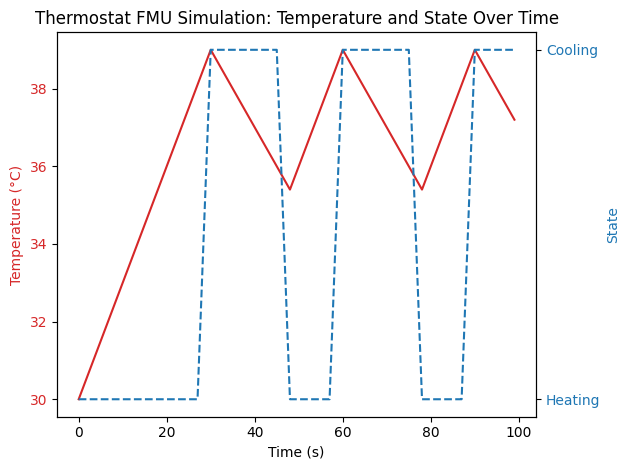

In [27]:
# Plotting the results
fig, ax1 = plt.subplots()

# Plot temperature over time
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Temperature (°C)', color='tab:red')
ax1.plot(time_values, temp_values, color='tab:red', label='Temperature')
ax1.tick_params(axis='y', labelcolor='tab:red')

# Plot the states (Heating, Cooling) over time using a secondary y-axis
ax2 = ax1.twinx()
ax2.set_ylabel('State', color='tab:blue')

# Convert states to numerical values for plotting
state_mapping = {"Heating": 1, "Cooling": 2}
numeric_states = [state_mapping[state] for state in state_values]
ax2.plot(time_values, numeric_states, color='tab:blue', linestyle='dashed', label='State')
ax2.tick_params(axis='y', labelcolor='tab:blue')

# Set the y-ticks for state labels
ax2.set_yticks([1, 2])
ax2.set_yticklabels(['Heating', 'Cooling'])

# Add a title and display the plot
plt.title('Thermostat FMU Simulation: Temperature and State Over Time')
fig.tight_layout()
plt.show()

Note how the access to the FMU is standardized: the lifecycle functions, as well as the fmi2DoStep functions, are the same regardless of what the behavior of the FMU is. The main difference is the access to the inputs, outputs, and parameters of the FMU. We're taking the shortcut since the FMU is a pure python object.